## Hierarchical Anchor-free Object Detection for Atypical and Typical Mitosis Subtyping

In [1]:
%load_ext autoreload
%autoreload 2
run = 1

In [2]:
import torch
import pickle
import numpy
from SlideRunner_dataAccess.database import Database
import pytorch_lightning as pl
import albumentations as A
import wandb

from src.datamodule import MitosisTwoSubclassDataModule
from src.fcos.litmodel import LitHFCOS


## Build annotations dictionary

In [3]:
db = 'databases_atypia/MIDOG.sqlite'
DB = Database().open(db)
classes = {x:y for x,y,_,_ in DB.getAllClasses() }
databases_directories = [['databases_atypia/MIDOG.sqlite', 'images_midog_training/'],
                         ['databases_atypia/MIDOG_preliminaryTest.sqlite', 'images_midog_preliminarytest/'],
                         ['databases_atypia/MIDOG_final_TestSet.sqlite', 'images_midog_finaltest/']]

annotations_dict={}
class_mapping = { 'mitotic figure' : -1,
                  'Mitosis - AMF OTHER': 0,
                  'Mitosis - AMF BIPOLAR ASYMMETRIC CAN ALSO HAVE SEGREGATION': 0,
                  'Mitosis - AMF MULTIPOLAR ASYMMETRY CAN ALSO HAVE SEGREGATION': 0,
                  'Mitosis - AMF SEGREGATION ONLY':0,
                  'Mitosis - RING SHAPE (PROMETAPHASE OR METAPHASE)': 1,
                  'Mitosis - NORMAL ANAPHASE-TELOPHASE': 2,
                  'Mitosis - NORMAL PROMETAPHASE': 3,
                  'Mitosis - NORMAL METAPHASE': 4
                }

subclass_names = ['N/A','AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE','PROMETAPHASE','METAPHASE']
value_to_class_DB = {y:x for x,y,_,_ in DB.getAllClasses() }
value_to_class = {x:y for x,y in enumerate(subclass_names) }


for dbfile, folder in databases_directories:
    DB.open(dbfile)
    for uid, fname in DB.listOfSlides()[0:150]:
        fname = folder+fname
        DB.loadIntoMemory(uid)
        annotations_dict[fname] = {}
        for annoI in DB.annotations:
            anno = DB.annotations[annoI]
            if (value_to_class_DB[anno.agreedClass] not in class_mapping): # skip non-mitotic figures
                cls = -2
            else:
                cls = class_mapping[value_to_class_DB[anno.agreedClass]]
            annotations_dict[fname][annoI] = {'x': [int(anno.x1-25),int(anno.x1+25)], 'y': [int(anno.y1-25), int(anno.y1+25)], 'class': cls}



In [4]:
annotations_dict[fname].values()

dict_values([{'x': [819, 869], 'y': [196, 246], 'class': -2}, {'x': [2354, 2404], 'y': [204, 254], 'class': 4}, {'x': [2207, 2257], 'y': [480, 530], 'class': 3}, {'x': [2688, 2738], 'y': [321, 371], 'class': -2}, {'x': [1603, 1653], 'y': [73, 123], 'class': -2}, {'x': [4997, 5047], 'y': [136, 186], 'class': -1}, {'x': [511, 561], 'y': [1751, 1801], 'class': 4}, {'x': [2309, 2359], 'y': [1100, 1150], 'class': -2}, {'x': [2598, 2648], 'y': [1710, 1760], 'class': -2}, {'x': [4302, 4352], 'y': [1715, 1765], 'class': -2}, {'x': [417, 467], 'y': [2314, 2364], 'class': 3}, {'x': [5955, 6005], 'y': [2501, 2551], 'class': 0}, {'x': [2919, 2969], 'y': [3233, 3283], 'class': -2}, {'x': [85, 135], 'y': [3980, 4030], 'class': -1}, {'x': [402, 452], 'y': [4402, 4452], 'class': 3}, {'x': [3112, 3162], 'y': [4209, 4259], 'class': 0}, {'x': [2786, 2836], 'y': [4108, 4158], 'class': -2}, {'x': [2932, 2982], 'y': [4500, 4550], 'class': -2}, {'x': [4168, 4218], 'y': [4904, 4954], 'class': 3}, {'x': [6129,

In [5]:
wandb.init(entity="imi", project="HFCOS", name='HFCOS-Mitosis-HE-run%d' % run)


wandb: Currently logged in as: maubreville (imi). Use `wandb login --relogin` to force relogin


In [6]:
import numpy as np
img_dir = './'
batch_size = 8
crop_size = (1024,1024)

num_workers = 8

transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.5),
    A.Cutout(p=0.2, max_w_size=100, max_h_size=100, num_holes=4),
    A.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.05, p=0.3)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['labels','sub_labels']))

# create datamodule
dm = MitosisTwoSubclassDataModule(img_dir,
                               annotations_dict,
                               labels=np.arange(-1,5), # labels for stratified sampling
                               batch_size=batch_size,
                               crop_size=crop_size,
                               num_workers = num_workers,
                               num_train_samples=2000,
                               num_val_samples=2000,
                               train_transforms = transform)


/home/aubreville/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Labels for sampling {-1: 546, 0: 200, 1: 25, 2: 98, 3: 524, 4: 573, -2: 4139}
Labels for sampling {-1: 128, 0: 57, 1: 3, 2: 22, 3: 150, 4: 184, -2: 1145}


In [7]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

wandb_logger = WandbLogger(name='HFCOS_l2', project="HFCOS")

model = LitHFCOS(batch_size = batch_size, subclass_names=subclass_names,
                                     num_classes = 2,optimizer='AdamW', scheduler='BaselineLRScheduler',
                                     num_subclasses = 2,num_subclasses_l2=4, backbone='resnet18')
model.subclass_w = [1,1]

trainer = pl.Trainer(max_epochs = 50, accelerator='gpu', 
                     callbacks=[EarlyStopping(monitor="val/loss", mode="min", verbose=True, patience=10)],
                     logger =wandb_logger, reload_dataloaders_every_n_epochs=1)

trainer.fit(model, datamodule=dm)

/home/aubreville/.local/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/home/aubreville/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/aubreville/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 5.008


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 3.401 >= min_delta = 0.0. New best score: 1.607


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.210 >= min_delta = 0.0. New best score: 1.396


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.116 >= min_delta = 0.0. New best score: 1.281


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.035 >= min_delta = 0.0. New best score: 1.246


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.048 >= min_delta = 0.0. New best score: 1.198


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.050 >= min_delta = 0.0. New best score: 1.148


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.006 >= min_delta = 0.0. New best score: 1.141


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val/loss did not improve in the last 10 records. Best score: 1.141. Signaling Trainer to stop.


In [8]:
categories_l1 = {-1:'undefined',0:'atypical',1:'typical'}
categories_l2 = {-1: 'undefined', 0:'RING SHAPE', 1:'ANAPHASE-TELOPHASE',2:'PROMETAPHASE',3:'METAPHASE'}


In [9]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from src.utils import match_scores_targets
model = model.eval().cuda()


all_gt_scores = []
all_predictions = []
all_gt_scores_l2 = []
all_predictions_l2 = []
all_logits = []
all_logits_l2 = []
with torch.no_grad():
    for n, (img,target) in enumerate(tqdm(dm.val_dataloader())):
        
        pred = model(img.cuda(),[{'boxes': y['boxes'].cuda(), 'labels': y['labels'].cuda(),
                                  'sub_labels': y['sub_labels'].cuda(), 'sub_labels_l2': y['sub_labels_l2'].cuda()} for y in target])[0]
        pred = [{x:y[x].cpu() for x in y } for y in pred]
        for p,t in zip(pred,target):
            boxes = p['boxes'].numpy()
            scores = p['scores'].numpy()
            scl_pred = p['sub_labels'].numpy()
            scl_pred_l2 = p['sub_labels_l2'].numpy()
            sclogits_pred = p['sub_logits'].numpy()
            sclogits_pred_l2 = p['sub_logits_l2'].numpy()
            
            annos = t['boxes'].numpy()
            scl_targets = t['sub_labels'].numpy()
            scl_targets_l2 = t['sub_labels_l2'].numpy()
            gt_scores, pred_scores,_,_ = match_scores_targets(boxes,scores,scl_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores_l2, pred_scores_l2,_,_ = match_scores_targets(boxes,scores,scl_pred_l2,annos,scl_targets_l2, radius = 25, det_th = 0.5)
            _, pred_logits,_,_ = match_scores_targets(boxes,scores,sclogits_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            _, pred_logits_l2,_,_ = match_scores_targets(boxes,scores,sclogits_pred_l2,annos,scl_targets_l2, radius = 25, det_th = 0.5)
            
            all_gt_scores.extend(gt_scores)
            all_predictions.extend(pred_scores)

            all_gt_scores_l2.extend(gt_scores_l2)
            all_predictions_l2.extend(pred_scores_l2)
    
            all_logits.extend(pred_logits)
            all_logits_l2.extend(pred_logits_l2)
            


  0%|          | 0/250 [00:04<?, ?it/s]

Text(0.5, 1.0, '2-Level Hierarchical Classifier, AUC=0.849')

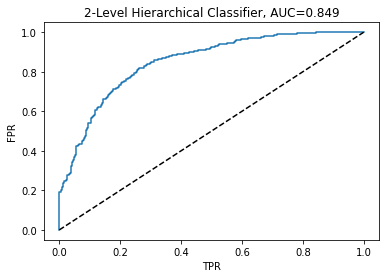

In [10]:
import matplotlib.pyplot as plt
sel = np.stack(all_gt_scores)>=0
from sklearn.metrics import roc_curve
fpr,tpr,thrs = roc_curve(y_score=np.stack(all_logits)[sel,1], y_true=np.stack(all_gt_scores)[sel])
plt.plot(fpr,tpr)
plt.xlabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.ylabel('FPR')

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_score=np.stack(all_logits)[sel,1], y_true=np.stack(all_gt_scores)[sel])
plt.title('2-Level Hierarchical Classifier, AUC=%.3f' % auc)



In [11]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm1 = confusion_matrix(y_true=all_gt_scores, y_pred=all_predictions)
cm2 = confusion_matrix(y_true=all_gt_scores_l2, y_pred=all_predictions_l2)
#



In [12]:
value_to_class.values()

dict_values(['N/A', 'AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE', 'PROMETAPHASE', 'METAPHASE'])

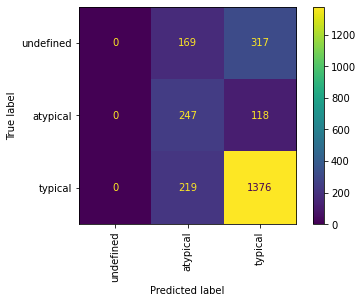

In [13]:
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[x for x in categories_l1.values()]).plot(xticks_rotation='vertical')


In [14]:
sens = cm1[1,1]/(cm1[1,1]+cm1[1,2])
spec = cm1[2,2]/(cm1[2,2]+cm1[2,1])

print(sens,spec)

0.6767123287671233 0.8626959247648903


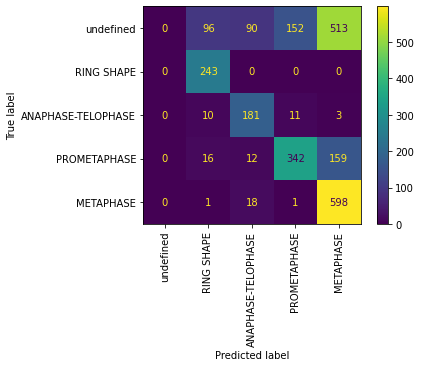

In [15]:
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[x for x in categories_l2.values() if 'not' not in x]).plot(xticks_rotation='vertical')


In [16]:
accuracy2 = np.sum((np.eye(5)*cm2))/np.sum(cm2[1:,:])
accuracy1 = np.sum((np.eye(3)*cm1))/np.sum(cm1[1:,:])

In [17]:
accuracy1, accuracy2

(0.8280612244897959, 0.8551724137931035)

In [18]:
cm_combined = confusion_matrix(y_true=np.array(all_gt_scores_l2)+np.array(all_gt_scores), y_pred=np.array(all_predictions_l2)+np.array(all_predictions))

In [19]:
cm_combined

array([[  0,   0,  28,  36,  37, 171, 214],
       [  0,   0,  43,  37,  78, 132,  75],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  24, 219,   0,   0,   0],
       [  0,   0,   7,  28, 161,   7,   2],
       [  0,   0,   9,   7,  23, 426,  64],
       [  0,   0,   1,   5,  13,  37, 562]])

In [20]:
subclass_names

['N/A', 'AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE', 'PROMETAPHASE', 'METAPHASE']

# Evaluate on TUPAC16

In [21]:
db = 'databases_atypia/TUPAC_alternativeLabels_augmented.sqlite'
DB = Database().open(db)
classes = {x:y for x,y,_,_ in DB.getAllClasses() }
databases_directories = [['databases_atypia/TUPAC_alternativeLabels_augmented.sqlite', 'images_mitosis_tupac16/'],
                         ]

annotations_dict_testset={}

class_mapping = { 'Mitose' : -1,
                  'Mitosis - AMF OTHER': 0,
                  'Mitosis - AMF BIPOLAR ASYMMETRIC CAN ALSO HAVE SEGREGATION': 0,
                  'Mitosis - AMF MULTIPOLAR ASYMMETRY CAN ALSO HAVE SEGREGATION': 0,
                  'Mitosis - AMF SEGREGATION ONLY':0,
                  'Mitosis - RING SHAPE (PROMETAPHASE OR METAPHASE)': 1,
                  'Mitosis - NORMAL ANAPHASE-TELOPHASE': 2,
                  'Mitosis - NORMAL PROMETAPHASE': 3,
                  'Mitosis - NORMAL METAPHASE': 4
                }

subclass_names = ['N/A','AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE','PROMETAPHASE','METAPHASE']
value_to_class_DB = {y:x for x,y,_,_ in DB.getAllClasses() }
value_to_class = {x:y for x,y in enumerate(subclass_names) }

skipped_classes=[]

for dbfile, folder in databases_directories:
    DB.open(dbfile)
    for uid, fname in DB.listOfSlides()[0:150]:
        fname = folder+fname
        DB.loadIntoMemory(uid)
        annotations_dict_testset[fname] = {}
        for annoI in DB.annotations:
            anno = DB.annotations[annoI]
            if (value_to_class_DB[anno.agreedClass] not in class_mapping): # skip non-mitotic figures
                skipped_classes.append(anno.agreedClass)
                continue
            cls = class_mapping[value_to_class_DB[anno.agreedClass]]
            annotations_dict_testset[fname][annoI] = {'x': [int(anno.x1-25),int(anno.x1+25)], 'y': [int(anno.y1-25), int(anno.y1+25)], 'class': cls}



In [22]:
from src.Dataset import HierarchicalSublabelsObjectsDataset
from torch.utils.data import DataLoader

testset = HierarchicalSublabelsObjectsDataset(annotations_dict=annotations_dict_testset,
                                      slide_names=list(annotations_dict_testset.keys()),
                                      path_to_slides='./',
                                      labels=np.arange(-1,5),
                                      crop_size=crop_size,
                                      sampling='continuous',
                                      pseudo_epoch_length=2000,
                                      transformations=None)
testset_dl = DataLoader(dataset = testset, batch_size = 8, shuffle = False, 
                        num_workers = 8, collate_fn = testset.collate_fn)

In [23]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from src.utils import match_scores_targets,get_number_of_fps
model = model.eval().cuda()

from torchmetrics.detection.mean_ap import MeanAveragePrecision

all_gt_scores = []
all_predictions = []
all_gt_scores_l2 = []
all_predictions_l2 = []
all_logits = []
all_logits_l2 = []
metrics={}
metric = MeanAveragePrecision(num_classes=2,iou_thresholds=[0.5], class_metrics=True)
overallp = 0
overallfp = 0
overalltp = 0

with torch.no_grad():
    for n, (img,target) in enumerate(tqdm(testset_dl)):
        pred = model(img.cuda(),[{'boxes': y['boxes'].cuda(), 'labels': y['labels'].cuda(),
                                  'sub_labels': y['sub_labels'].cuda(), 'sub_labels_l2': y['sub_labels_l2'].cuda()} for y in target])[0]
        pred = [{x:y[x].cpu() for x in y } for y in pred]
        for p,t in zip(pred,target):
            boxes = p['boxes'].numpy()
            scores = p['scores'].numpy()
            scl_pred = p['sub_labels'].numpy()
            scl_pred_l2 = p['sub_labels_l2'].numpy()
            sclogits_pred = p['sub_logits'].numpy()
            sclogits_pred_l2 = p['sub_logits_l2'].numpy()
            
            annos = t['boxes'].numpy()
            scl_targets = t['sub_labels'].numpy()
            scl_targets_l2 = t['sub_labels_l2'].numpy()
            gt_scores, pred_scores,_,_ = match_scores_targets(boxes,scores,scl_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores_l2, pred_scores_l2,_,_ = match_scores_targets(boxes,scores,scl_pred_l2,annos,scl_targets_l2, radius = 25, det_th = 0.5)
            _, pred_logits,_,_ = match_scores_targets(boxes,scores,sclogits_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            _, pred_logits_l2,_,_ = match_scores_targets(boxes,scores,sclogits_pred_l2,annos,scl_targets_l2, radius = 25, det_th = 0.5)
            
            all_gt_scores.extend(gt_scores)
            all_predictions.extend(pred_scores)

            all_gt_scores_l2.extend(gt_scores_l2)
            all_predictions_l2.extend(pred_scores_l2)
    
            all_logits.extend(pred_logits)
            all_logits_l2.extend(pred_logits_l2)
            fps = get_number_of_fps(boxes,scores,annos)
            overallfp = overallfp + fps

            overalltp = overalltp+len(pred_scores)
            overallp = overallp+len(annos)
            # update metrics
            targets=target
            for idx, sample in enumerate(targets):
                if sample['boxes'].size(0) == 0:
                    targets[idx]['boxes'] = torch.zeros((1, 4), dtype=torch.float32)
                    # === geändert wegen dataset Änderung === #
                    targets[idx]['labels'] = torch.tensor([0],dtype=torch.int64)
            metric.update(pred[0:len(targets)], targets)
metrics = metric.compute()
metrics['precision'] = overalltp / (overalltp + overallfp)
metrics['recall'] = overalltp / (overallp)
         

  0%|          | 0/1197 [00:09<?, ?it/s]

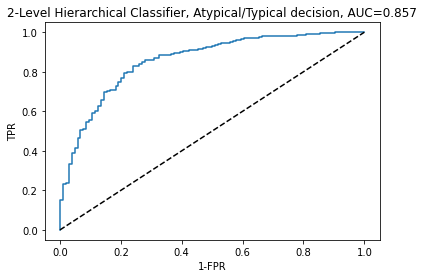

In [24]:
sel = np.stack(all_gt_scores)>=0
from sklearn.metrics import roc_curve
fpr,tpr,thrs = roc_curve(y_score=np.stack(all_logits)[sel,1], y_true=np.stack(all_gt_scores)[sel])
plt.plot(fpr,tpr)
plt.ylabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('1-FPR')

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_score=np.stack(all_logits)[sel,1], y_true=np.stack(all_gt_scores)[sel])
plt.title('2-Level Hierarchical Classifier, Atypical/Typical decision, AUC=%.3f' % auc)
plt.savefig('ROC_atypical_typical_2_level_run%d.svg' % run)



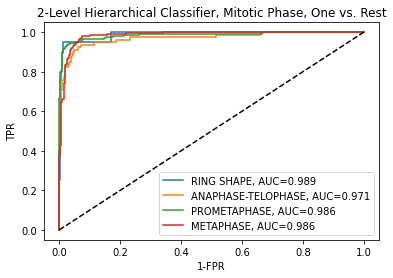

In [25]:
sel = np.stack(all_gt_scores_l2)>=0
from sklearn.metrics import roc_curve
for i in range(4):
    fpr,tpr,thrs = roc_curve(y_score=np.stack(all_logits_l2)[sel,i], y_true=np.stack(all_gt_scores_l2)[sel]==i)
    auc = roc_auc_score(y_score=np.stack(all_logits_l2)[sel,i], y_true=np.stack(all_gt_scores_l2)[sel]==i)
    plt.plot(fpr,tpr, label=f'{list(categories_l2.values())[i+1]}, AUC={auc:.3f}')

plt.ylabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('1-FPR')

from sklearn.metrics import roc_auc_score
plt.legend()
plt.title(f'2-Level Hierarchical Classifier, Mitotic Phase, One vs. Rest')

#, AUC={auc:.3f}'  )
plt.savefig('ROC_mitotic_phase_2_level_run%d.svg' % run)


In [26]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm1 = confusion_matrix(y_true=all_gt_scores, y_pred=all_predictions)
cm2 = confusion_matrix(y_true=all_gt_scores_l2, y_pred=all_predictions_l2)


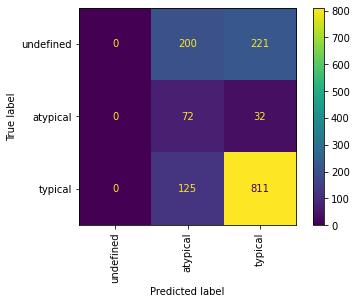

In [27]:
ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[x for x in categories_l1.values()]).plot(xticks_rotation='vertical')


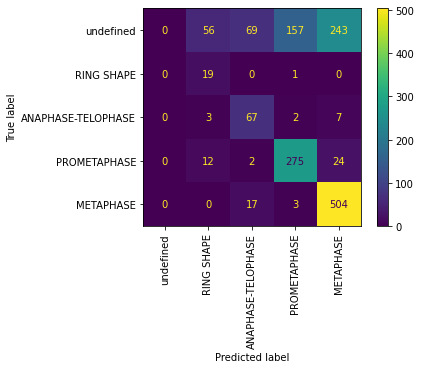

In [28]:
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[x for x in categories_l2.values()]).plot(xticks_rotation='vertical')


In [29]:
torch.save({'cm1':cm1,'cm2':cm2,
                              'all_gt_scores': all_gt_scores,
                              'all_gt_scores_l2': all_gt_scores_l2,
                              'all_predictions':all_predictions,
                              'all_predictions_l2': all_predictions_l2, 'metrics': metrics}, 'run%d_hfcos.pth' % run)

In [30]:
run

14